In [33]:
#this notebook uses the entire dataset (that is not included in this release, see repo README)
#we provide it to show how the results/figures/tables of the paper are generated

import numpy as np
import pandas as pd
name = "ds806" #change it to your name
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt 
%matplotlib inline
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
import seaborn as sns
sns.set_context("poster")
import glob
from sklearn.decomposition import PCA
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from utils import *
import time
import os

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge,ElasticNet, Lasso, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.externals import joblib

from keras.layers import Input, Dense, Dropout,BatchNormalization
from keras.models import Model, load_model,model_from_json
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
frame = pd.read_csv("data/extracted_features_all_users_with_MVPA_noncal.csv", index_col=0)
frame.head()

,25%_ACC,25%_ENMO,25%_MET_LPA,25%_MET_MVPA,25%_MET_VigPA,25%_MET_sed,25%_MVPA_noncal,25%_Sed_noncal,25%_VPA_noncal,25%_hrv_milliseconds,25%_mean_hr,50%_ACC,50%_ENMO,50%_MET_LPA,50%_MET_MVPA,50%_MET_VigPA,50%_MET_sed,50%_MVPA_noncal,50%_Sed_noncal,50%_VPA_noncal,50%_hrv_milliseconds,50%_mean_hr,75%_ACC,75%_ENMO,75%_MET_LPA,75%_MET_MVPA,75%_MET_VigPA,75%_MET_sed,75%_MVPA_noncal,75%_Sed_noncal,75%_VPA_noncal,75%_hrv_milliseconds,75%_mean_hr,RHR,age,bmi,count_ACC,count_ENMO,count_MET_LPA,count_MET_MVPA,count_MET_VigPA,count_MET_sed,count_MVPA_noncal,count_Sed_noncal,count_VPA_noncal,count_hrv_milliseconds,count_mean_hr,height,id,max_ACC,max_ENMO,max_MET_LPA,max_MET_MVPA,max_MET_VigPA,max_MET_sed,max_MVPA_noncal,max_Sed_noncal,max_VPA_noncal,max_hrv_milliseconds,max_mean_hr,mean_ACC,mean_ENMO,mean_MET_LPA,mean_MET_MVPA,mean_MET_VigPA,mean_MET_sed,mean_MVPA_noncal,mean_Sed_noncal,mean_VPA_noncal,mean_hrv_milliseconds,mean_mean_hr,min_ACC,min_ENMO,min_MET_LPA,min_MET_MVPA,min_MET_VigPA,min_MET_sed,min_MVPA_noncal,min_Sed_noncal,min_VPA_noncal,min_hrv_milliseconds,min_mean_hr,month,month_cos_time,month_sin_time,mvpa_daily_count,mvpa_daily_count_noncal,real_time,sed_daily_count,sed_daily_count_noncal,sex,slope_ACC,slope_ENMO,slope_MET_LPA,slope_MET_MVPA,slope_MET_VigPA,slope_MET_sed,slope_MVPA_noncal,slope_Sed_noncal,slope_VPA_noncal,slope_hrv_milliseconds,slope_mean_hr,std_ACC,std_ENMO,std_MET_LPA,std_MET_MVPA,std_MET_VigPA,std_MET_sed,std_MVPA_noncal,std_Sed_noncal,std_VPA_noncal,std_hrv_milliseconds,std_mean_hr,vpa_daily_count,vpa_daily_count_noncal,weight
0,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,66.375999,0.015,2.543696,0.0,0.0,0.0,0.0,0.0,0.009,0.0,157.0,77.554001,0.234,38.849461,0.000000,0.000000,0.0,0.000000,0.0,0.216,0.0,211.0,89.494501,62.666730,46.0,28.563646,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,8258.0,1.839,608551N,3.297,546.632812,5.958082,5.958082,5.958082,0.499869,3.297,0.975,0.000,1555.0,136.427002,0.157728,26.205971,0.503840,0.307573,0.000721,0.026814,0.030209,0.127520,0.000000,175.058519,78.724571,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-180.0,52.365002,3.0,6.123234e-17,1.000000,168.833333,26.166667,2011-03-17 12:38:00,1179.714286,1179.714286,1.0,-0.000008,-0.001269,-0.000055,-0.000047,-2.005316e-07,1.034424e-07,-0.000004,-3.796540e-06,0.000000e+00,0.005148,-0.001517,0.289485,47.991135,0.940380,0.836552,0.065565,0.068968,0.231807,0.194346,0.000000,93.889429,14.898837,1.000000,0.000000,96.6
1,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.0,72.498001,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,203.0,79.259003,0.036,6.025071,0.000000,0.000000,0.0,0.018802,0.0,0.033,0.0,563.0,86.390999,68.391240,47.0,23.403175,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,9421.0,1.743,705051H,2.997,496.898895,4.474391,4.474391,0.000000,0.497736,2.997,0.975,0.000,1821.0,127.177002,0.063776,10.629453,0.146806,0.066505,0.000000,0.044098,0.019868,0.043908,0.000000,371.541575,79.729309,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1547.0,58.625999,1.0,8.660254e-01,0.500000,32.125000,18.000000,2010-01-23 18:45:00,1177.625000,1177.625000,0.0,-0.000003,-0.000547,0.000010,-0.000002,0.000000e+00,-1.020129e-08,-0.000004,8.523049e-07,0.000000e+00,0.007257,0.000887,0.203587,33.752403,0.531500,0.403107,0.000000,0.089634,0.177140,0.108699,0.000000,350.484761,10.069210,0.000000,0.000000,71.1
2,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,57.288500,0.000,0.057000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,70.0,65.306499,0.144,23.929281,0.000000,0.000000,0.0,0.000000,0.0,0.048,0.0,109.0,72.082998,55.442856,49.0,27.513542,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,8678.0,1.740,612538F,7.608,1261.309326,8.154249,8.154249,8.154249,0.497530,7.608,0.984,7.608,1703.0,137.863998,0.276521,45.900051,0.603344,0.460276,0.022634,0.034609,0.201595,0.074926,0.006138,105.800578,65.706253,0.0,0.057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1281.0,45.201000,7.0,-8.660254e-01,-0.500000,184.571429,109.428571,2013-07-25 12:40:00

In [3]:
frame.shape

(12158, 116)

### Introduce the VO2max label

#### Fenland I

In [4]:
#Fenland 1 
fitness_df = pd.read_csv("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/PHFENLANDR90002152019_26Nov2019/PHFENLANDR90002152019B_Prerelease_08Apr2020.csv")
fitness_df.index = fitness_df['serno'] #move the user_id to index
del fitness_df['serno']
fitness_df = fitness_df[['P_TR_FITNESS_HighPt_est']] #standartize column names with FII
fitness_df.rename(columns={'P_TR_FITNESS_HighPt_est': 'TR_FITNESS_HighPt_est'}, inplace=True)
fitness_df.shape

(12435, 1)

In [5]:
#merge Fenland 1 with sensors and remove missing fitness entries
frame_with_fitness =  pd.merge(frame, fitness_df, left_on='id', right_on='serno').dropna(how='any') 
frame_with_fitness.shape

(11059, 117)

In [6]:
#remove timestamp, count_ features and index (somehow the feature extraction created an index column)
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('real_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('count_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.startswith('index')]

#remove treadmill informed MVPA variables
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.contains('_MET_')]
frame_with_fitness = frame_with_fitness.loc[:,~frame_with_fitness.columns.str.endswith('daily_count')]

frame_with_fitness.shape

(11059, 70)

#### Fenland II

In [7]:
#Fenland 2 repeats
fitness_df_2 = pd.read_stata("/home/"+name+"/rds/rds-rjh234-deeplearning/FENLAND2/Releases_CRF_project/Fen2_Summary_fitness_vars_Apr_2020/Fen2_summary_fitness_vars_IP_8Apr2020.dta")
fitness_df_2['id'] = fitness_df_2.id[:-2].astype(str).str[:-2]
fitness_df_2["bmi"] = fitness_df_2["weight"] / (fitness_df_2["height"] * fitness_df_2["height"])
fitness_df_2 = fitness_df_2[['id','age', 'bmi', 'height', 'weight','TR_FITNESS_HighPt_est']] 
fitness_df_2.shape

(3041, 6)

In [8]:
#we merge the repeats with FI and generate two ID groups so that we can select train/test sets later
#we reset the index because it was creating issues in disjoint splits later
repeats = pd.merge(frame_with_fitness, fitness_df_2, on='id', suffixes = ("_f1","_repeats")).dropna(how='any').reset_index(drop=True)
IDs_repeats = frame_with_fitness[frame_with_fitness['id'].isin(repeats.id)].id
IDs_controls = frame_with_fitness[~frame_with_fitness['id'].isin(repeats.id)].id
print (repeats.shape,IDs_repeats.shape, IDs_controls.shape)

(2675, 75) (2675,) (8384,)


### Create new outcome (delta of present - future)

In [9]:
repeats["fitness_delta"] = repeats.TR_FITNESS_HighPt_est_f1-repeats.TR_FITNESS_HighPt_est_repeats

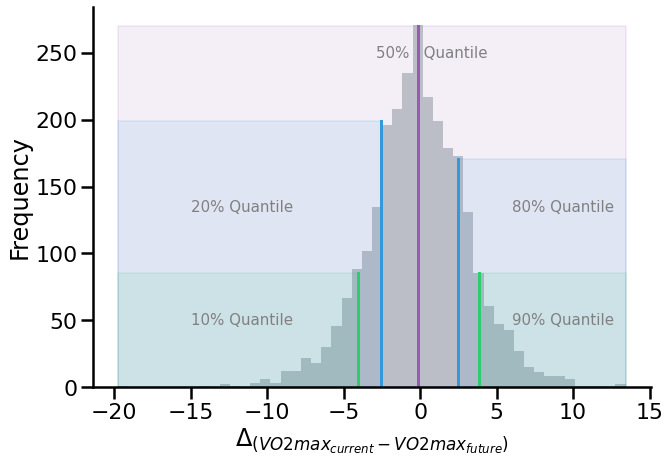

In [349]:
plt.figure(figsize=(10,7))
ax=repeats["fitness_delta"].hist(bins=50,color=flatui[2],alpha=0.6)

#median
ax.text(-2.9, 250, "50%   Quantile", rotation=0, verticalalignment='center', fontsize=15, color='grey')
plt.axvline(x=repeats["fitness_delta"].median(), ymax=0.95, color=flatui[0]) #median
ax.axvspan(repeats["fitness_delta"].min(), repeats["fitness_delta"].max(), ymax=0.95, alpha=0.1, color=flatui[0])

#20/80
ax.text(-15, 135, "20% Quantile", rotation=0, verticalalignment='center', fontsize=15, color='grey')
ax.text(6, 135, "80% Quantile", rotation=0, verticalalignment='center', fontsize=15, color='grey')
plt.axvline(x=repeats["fitness_delta"].quantile(0.2),ymax=0.7, color=flatui[1])
plt.axvline(x=repeats["fitness_delta"].quantile(0.8), ymax=0.6, color=flatui[1])
ax.axvspan(repeats["fitness_delta"].min(), repeats["fitness_delta"].quantile(0.2),ymax=0.7, alpha=0.1, color=flatui[1])
ax.axvspan(repeats["fitness_delta"].quantile(0.8), repeats["fitness_delta"].max(), ymax=0.6,alpha=0.1, color=flatui[1])

#10/90
ax.text(-15, 50, "10% Quantile", rotation=0, verticalalignment='center', fontsize=15, color='grey')
ax.text(6, 50, "90% Quantile", rotation=0, verticalalignment='center', fontsize=15, color='grey')
plt.axvline(x=repeats["fitness_delta"].quantile(0.1),ymax=0.3 ,color=flatui[5])
plt.axvline(x=repeats["fitness_delta"].quantile(0.9),ymax=0.3, color=flatui[5])
ax.axvspan(repeats["fitness_delta"].min(), repeats["fitness_delta"].quantile(0.1),ymax=0.3, alpha=0.1, color=flatui[5])
ax.axvspan(repeats["fitness_delta"].quantile(0.9), repeats["fitness_delta"].max(), ymax=0.3,alpha=0.1, color=flatui[5])

plt.xlabel('$\Delta_{(VO2max_{current}-VO2max_{future})}$'); plt.ylabel('Frequency')
sns.despine()
ax.grid(False)
plt.savefig('data/FII_binary_distros.pdf', bbox_inches="tight") 

### Split to disjoint train/test sets

In [269]:
outcome = '9010'

In [270]:
#split in two disjoint groups of users
#https://stackoverflow.com/questions/44007496/random-sampling-with-pandas-data-frame-disjoint-groups

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=143)

idx1, idx2 = next(gss.split(repeats, groups=repeats.id))
print(idx1.shape, idx2.shape)
    # Get the split.                                           #this iloc :-1 changed to :-2 bc we have two outcomes now (delta)
X_train, y_train = repeats.iloc[idx1,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2],repeats.loc[idx1,'fitness_delta'] 
X_test, y_test = repeats.iloc[idx2,~repeats.columns.str.endswith('_repeats')].iloc[:,:-2], repeats.loc[idx2,'fitness_delta']

if outcome == 'binary':
    y_train = np.where(repeats.loc[idx1,'fitness_delta'] < repeats.loc[idx1,'fitness_delta'].quantile(1/2), 0, 1)
    y_test = np.where(y_test < repeats.loc[idx1,'fitness_delta'].quantile(1/2), 0, 1)
    
elif outcome == '8020':
    y_train = np.where(repeats.loc[idx1,'fitness_delta'] < repeats.loc[idx1,'fitness_delta'].quantile(2/10), 0, 
                       (np.where(repeats.loc[idx1,'fitness_delta'] > repeats.loc[idx1,'fitness_delta'].quantile(8/10), 1, 2)))
    y_test = np.where(y_test < repeats.loc[idx1,'fitness_delta'].quantile(2/10), 0, 
                      (np.where(y_test > repeats.loc[idx1,'fitness_delta'].quantile(8/10), 1, 2)))

elif outcome == '9010':
    y_train = np.where(repeats.loc[idx1,'fitness_delta'] < repeats.loc[idx1,'fitness_delta'].quantile(1/10), 0, 
                       (np.where(repeats.loc[idx1,'fitness_delta'] > repeats.loc[idx1,'fitness_delta'].quantile(9/10), 1, 2)))
    y_test = np.where(y_test < repeats.loc[idx1,'fitness_delta'].quantile(1/10), 0, 
                      (np.where(y_test > repeats.loc[idx1,'fitness_delta'].quantile(9/10), 1, 2)))


#make sure test users do not appear in train set
mask = np.isin(X_test.id, X_train.id)
assert mask.all() == False

#drop the userID (string hence keep only numeric data)
X_train = X_train._get_numeric_data()
X_test = X_test._get_numeric_data()

print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2140,) (535,)
(2140, 68) (535, 68) (2140,) (535,)


In [271]:
if outcome is not "binary":
    #drop the neutral class ==2
    X_train = X_train[(y_train==0) |  (y_train==1)]
    y_train = y_train[(y_train==0) |  (y_train==1)]

    X_test = X_test[(y_test==0) |  (y_test==1)]
    y_test = y_test[(y_test==0) |  (y_test==1)]

In [272]:
#flag to train only with anthro/metadata
antrhopometrics = False

In [273]:
if antrhopometrics==True:
    X_train = X_train[[ 'height_f1', 'weight_f1', 'sex', 'age_f1', 'bmi_f1','RHR']] #'RHR'
    X_test = X_test[[ 'height_f1', 'weight_f1', 'sex', 'age_f1', 'bmi_f1','RHR']] #'RHR'
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)  
print (X_train.shape[0]+X_test.shape[0])

(428, 68) (107, 68) (428,) (107,)
535


### Normalize and denoise (PCA)

In [274]:
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
scaler_name = "data/scaler_FI.save"
scaler = joblib.load(scaler_name)

#scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Explained variance: [0.20149605 0.33074457 0.42186119 0.50326178 0.56430508 0.61880589
 0.66000795 0.69394318 0.72397252 0.75197558 0.77644784 0.79732965
 0.81781495 0.83603146 0.85179296 0.86694154 0.88198426 0.89614
 0.90984366 0.92306865 0.93498154 0.9445445  0.95308949 0.9606058
 0.96714091 0.97284774 0.9776114  0.98180186 0.98499349 0.98765217
 0.99011806 0.99227324 0.99397499 0.99559123 0.99689999 0.9977105
 0.99830882 0.99888394 0.99928636 0.99951151 0.99969266 0.99982739
 0.99988132 0.99993433]


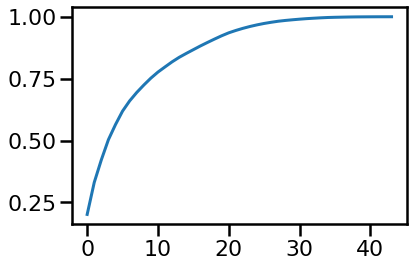

In [275]:
pca_flag = True
if pca_flag==True:
    scaler_pca = "data/PCA_FI_mapping_09999.save"
    pca_mapping = joblib.load(scaler_pca)
    #pca_explained = 0.9999
    pca = pca_mapping
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print ("Explained variance:", pca.explained_variance_ratio_.cumsum()) 
    plt.plot(pca.explained_variance_ratio_.cumsum())

In [276]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)    

(428, 44) (107, 44) (428,) (107,)


In [277]:
from keras.utils.np_utils import to_categorical
y_train_tensor = to_categorical(y_train)
y_test_tensor = to_categorical(y_test)

### Train model

In [278]:
training_mode = 'NN'

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 44)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               5760      
_________________________________________________________________
batch_normalization_11 (Batc (None, 128)               512       
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 258       
Total params: 6,530
Trainable params: 6,274
Non-trainable params: 256
_________________________________________________________________
Train on 385 samples, validate on 43 samples
Epoch 1/500
385/385 [==============================] - 1s 3ms/step - loss: 0.9920 - acc: 0.53

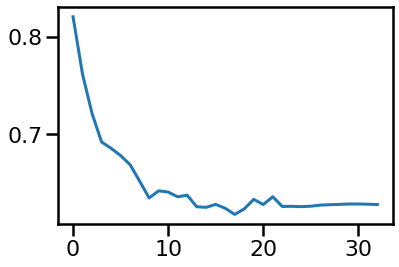

In [340]:
if training_mode=='linear_model':
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(class_weight='balanced')
    clf = model.fit(X_train, y_train)
    print (clf)
elif training_mode=='NN':
    input_layer = Input(shape=(X_train.shape[1],))    
    x = Dense(128, activation='elu',)(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    final = Dense(2, activation='sigmoid')(x)

    clf = Model(input_layer, final)
    clf.summary()
    clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Create a folder and store the model
    model_time = time.strftime("%Y%m%d-%H%M%S") #use timestamp as folder name...
    path = 'models/%s/'%model_time
    os.makedirs(os.path.dirname('./models/%s/'%model_time))
    # Save architecture for this model
    open('models/%s/model_architecture.json'%model_time, 'w').write(clf.to_json())

    #DON'T CHANGE THE FILEPATH NAMING CONVENTION, THE EVALUATION SCRIPT PARSING DEPENDS ON IT
    filepath="models/%s/weights-regression-improvement-{val_loss:.2f}.hdf5"%model_time
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
       factor=0.1,
       patience=5,
       verbose=1)

    checkpointer = ModelCheckpoint(monitor='val_loss', filepath=filepath, verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='auto')

    history = clf.fit(X_train, y_train_tensor, callbacks=[early_stop,reduce_lr,checkpointer], #change to y_train for supervised mode, or X_train for AE
                    epochs=500,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.1)
    plt.plot(history.history['val_loss'])

### Evaluation

In [342]:
if training_mode=='NN':
    del clf
    folder = model_time # or use another model e.g. '20200115-105719'
    #load best model from the folder
    clf = model_from_json(open('./models/'+ folder +'/model_architecture.json').read())
    files = glob.glob('./models/'+folder+'/*.hdf5')
    #WARNING! DEPENDS ON THE NAMING CONVENTION!
    #we parse the filename ('./models/20191029-125927/weights-regression-improvement-51.03.hdf5')
    #and we convert the MSE to a float in order to sort, the first is the lowest (lowest val_loss)
    weights = sorted(files, key=lambda name: float(name[56:-5]))[0]
    print ("=============Best model loaded:", weights)
    clf.load_weights(weights)   
    clf.compile(loss="mse", optimizer="adam")

=============Best model loaded: ./models/20201222-175328/weights-regression-improvement-0.62.hdf5


In [343]:
predicted = clf.predict(X_test)

#probs = clf.predict_proba(X_test)

#only for NNs
probs = np.argmax(predicted, axis=-1)

from sklearn import metrics
print (metrics.accuracy_score(y_test, probs))
print (metrics.roc_auc_score(y_test, predicted[:, 1]))
print (metrics.f1_score(y_test, probs))

print (metrics.confusion_matrix(y_test, probs))
print (metrics.classification_report(y_test, probs))

0.6261682242990654
0.7415966386554622
0.6153846153846153
[[35 16]
 [24 32]]
              precision    recall  f1-score   support

           0       0.59      0.69      0.64        51
           1       0.67      0.57      0.62        56

    accuracy                           0.63       107
   macro avg       0.63      0.63      0.63       107
weighted avg       0.63      0.63      0.63       107



In [344]:
#save true and predictions in order to plot AUCs below
np.save("data/"+outcome+"_ytest.npy", y_test) 
np.save("data/"+outcome+"_predicted.npy", predicted[:, 1]) 

### Plot aggregate ROC AUC of all 3 tasks

In [345]:
np.random.seed(1234)
rng=np.random.RandomState(1234)

#https://sites.google.com/site/lisaywtang/tech/python/scikit/auc-conf-interval
def get_ci_auc( y_true, y_pred ): 
    from scipy.stats import sem
    from sklearn.metrics import roc_auc_score    
    n_bootstraps = 500   
    bootstrapped_scores = []      
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
       
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)   
 
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
   
    return confidence_lower,confidence_upper


In [346]:
binary_ytest = np.load("data/binary_ytest.npy") 
binary_predicted = np.load("data/binary_predicted.npy") 

eighty_ytest = np.load("data/8020_ytest.npy") 
eighty_predicted = np.load("data/8020_predicted.npy") 

ninety_ytest = np.load("data/9010_ytest.npy") 
ninety_predicted = np.load("data/9010_predicted.npy") 

In [347]:
low_CI_binary, high_CI_binary = get_ci_auc(binary_ytest, binary_predicted)
low_CI_80, high_CI_80 = get_ci_auc(eighty_ytest, eighty_predicted)
low_CI_90, high_CI_90 = get_ci_auc(ninety_ytest, ninety_predicted)

/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 534 + 1) instead
  if sys.path[0] == '':
/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 534 + 1) instead
  if sys.path[0] == '':
/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 534 + 1) instead
  if sys.path[0] == '':
/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 534 + 1) instead
  if sys.path[0] == '':
/home/ds806/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: This function is deprecated. Please call randint(0, 534 + 1) instead
  if sys.path[0] == '':
/home/ds806/anaconda3/lib/python3.6/site-packages/ipyke

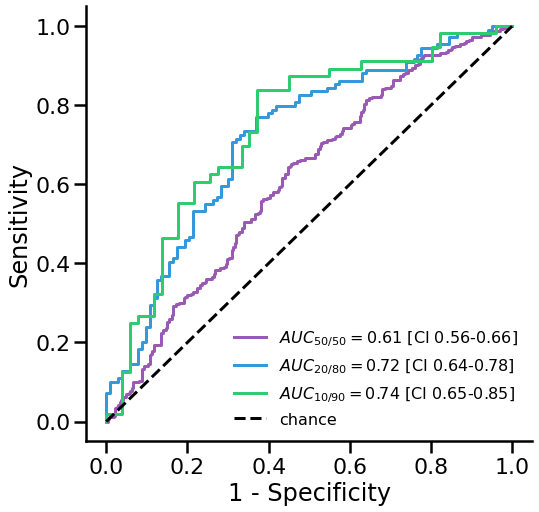

In [357]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


plt.figure(figsize=(8,8))
fpr, tpr, thresholds = roc_curve(binary_ytest, binary_predicted)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='$AUC_{50/50} = $' + str(np.around(roc_auc, decimals=2)) + ' [CI '+ str(np.around(low_CI_binary, decimals=2)) + '-' + str(np.around(high_CI_binary, decimals=2)) + ']', color=flatui[0])

fpr, tpr, thresholds = roc_curve(eighty_ytest, eighty_predicted)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='$AUC_{20/80} = $' + str(np.around(roc_auc, decimals=2)) + ' [CI '+ str(np.around(low_CI_80, decimals=2)) + '-' + str(np.around(high_CI_80, decimals=2)) + ']', color=flatui[1])

fpr, tpr, thresholds = roc_curve(ninety_ytest, ninety_predicted)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='$AUC_{10/90} = $' + str(np.around(roc_auc, decimals=2)) + ' [CI '+ str(np.around(low_CI_90, decimals=2)) + '-' + str(np.around(high_CI_90, decimals=2)) + ']', color=flatui[5])


plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc="lower right",frameon=False, prop={'size': 16})
sns.despine()
plt.savefig('data/FII_binary_AUCs.pdf', bbox_inches="tight") 